In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from oasis.functions import deconvolve
from sklearn import preprocessing
from sys import path
from scipy import signal
path.append('..')

In [26]:
FRAMERATE=20

In [314]:
def cluster_spikes(raw_spikes):
    clusters = []
    a = 40
    
    cluster = []
    for i in range(len(raw_spikes)-1):
        spike1 = raw_spikes[i]
        spike2 = raw_spikes[i+1]
        if len(cluster) == 0:
            cluster.append(spike1)
    
        diff = abs(spike1-spike2)
        if diff >= a:
            cluster.append(spike1)
            clusters.append(cluster)
            cluster=[]
       
    cluster.append(spike1)
    clusters.append(cluster)
    binned_spikes = np.median(clusters, axis=1) 
    
    return binned_spikes

In [2]:
single_trace = pd.read_excel('Book1.xlsx', header=None, dtype=np.float32)

In [3]:
scaler = preprocessing.StandardScaler()
zscore_trace = scaler.fit_transform(single_trace, [0, 1])
zscore_trace = pd.DataFrame(zscore_trace)[0].values

In [4]:
denoised_signal, spikes, _, _, _ = deconvolve(zscore_trace, g=(None, None), penalty=1, optimize_g=1, max_iter=5) 

D:\miniforge3\envs\oasis\lib\site-packages\oasis\functions.py:171: UserWarning: Optimization of AR parameters is already fairly stable for AR(1), but slower and more experimental for AR(2)
  warn("Optimization of AR parameters is already fairly stable for AR(1), "


In [54]:
def find_spikes(data):
    distance = FRAMERATE * 0.4
    spike_width = FRAMERATE * 0.9
    height = 1 # All spikes >1SD from mean
    # 0.5s is ~1/2 the max decay time of a 6CAMP6F transient (Chen et al. 2013)
    
    spikes = signal.find_peaks(denoised_signal, height = 1, width=spike_width, distance=distance)
    # distance of 10 is 1/2
    fig, ax = plt.subplots(figsize=(150, 5))
    
    ax.plot(data)
    ax.vlines(spikes[0], linewidth=0.3, color='r', ymin=0, ymax=max(data))
    
    fig.savefig('SpikeTest.pdf')
    return spikes

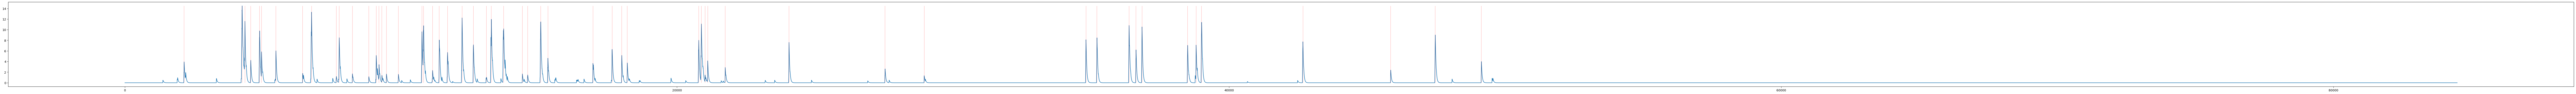

In [52]:
found_spikes = find_spikes(denoised_signal)

In [318]:
spikes_loc = np.nonzero(spikes)[0]
binned_spikes = cluster_spikes(spikes_loc)

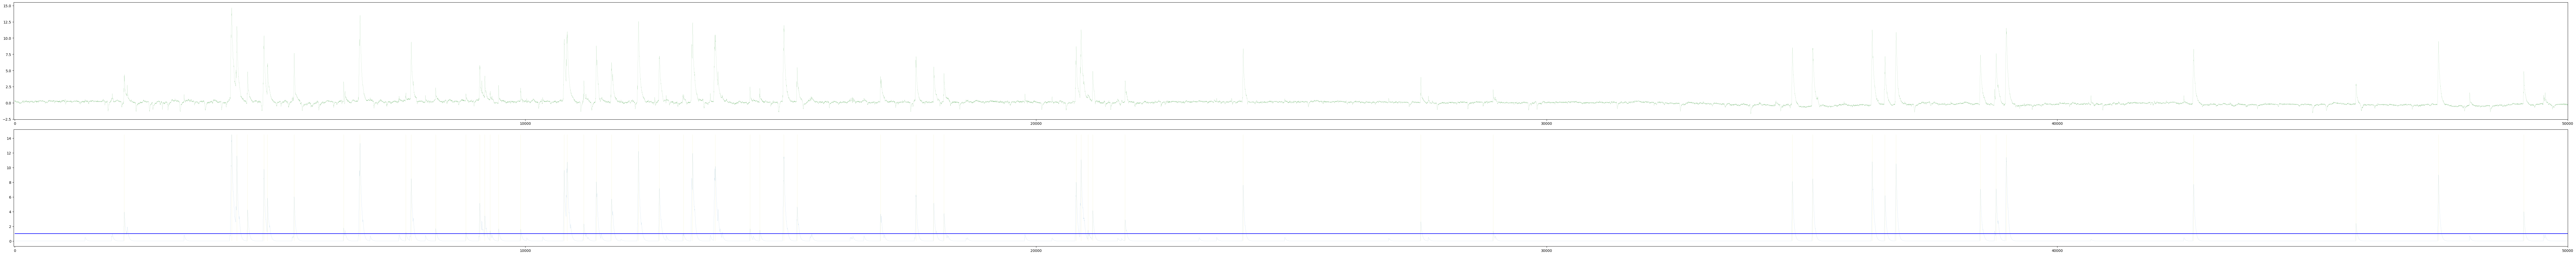

In [53]:
fig, ax = plt.subplots(2, figsize=(100, 10))
#.xticks(np.arange(0,50000, 5))

x1 = 4000
x2 = 4500

ax[0].plot(zscore_trace, linewidth=0.1, color='g')
# ax[0].vlines(found_spikes[0], color='m', linewidth = 0.1, ymin=min(zscore_trace), ymax=max(zscore_trace))
ax[1].plot(denoised_signal, linewidth=0.1)
ax[1].vlines(found_spikes[0], color='y', linewidth = 0.1, ymin=0, ymax=max(denoised_signal))
ax[1].hlines([1], color='b', xmin=0, xmax=len(denoised_signal))

for each in ax:
    each.set_xlim(-20, 50000)

#ax[3].set_xlim(-20, 50000)

plt.tight_layout()
fig.savefig('DeconvolutionTest-FoundSpikes.pdf')